# Stock Price Prediction Using Random Forest

In this notebook, we will be exploring the performance of the random forest classifier on the S&P500 stock data.

Sources:
 - [Exponential Smoothing](https://medium.com/@criesin.90days/stock-price-forecasting-with-exponential-smoothing-an-analytical-project-report-380c7ca694a8)
 - [The Random Forest Model for Analyzing and Forecasting the US Stock Market in the Context of Smart Finance](https://arxiv.org/pdf/2402.17194)

In [63]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# Suppress warnings for cleaner output
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Data Preprocessing

We decided to follow the paper's approach and apply **Exponential Smoothing** to our data, which assigns greater weight to more recent examples. 

We do this because the stock prices are more likely to follow recent patterns, rather than patterns from years ago.

In [64]:
df_apple = pd.read_csv('./clean_csvs/AAPL.csv')

df = pd.read_csv('./clean_csvs/AAPL.csv')

df_apple_smooth = df_apple.copy()
df_apple_smooth.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


In order to determine the alpha and beta values for exponential smoothing, we decided to follow [this website's approach](https://medium.com/@criesin.90days/stock-price-forecasting-with-exponential-smoothing-an-analytical-project-report-380c7ca694a8), by using **The Ordinary Least Squares (OLS) method**.

# Needs Fixing!

---

In order to do so, we will be using the **`statsmodels`** library, which is commonly imported as **`sm`**. This library provides tools for statistical modeling, including Ordinary Least Squares (OLS) regression, which we'll use to calculate **alpha** and **beta**.

Specifically:

1. **Alpha** and **Beta** are calculated through a **linear regression analysis**:
   - **Alpha** represents the intercept of the regression line. It quantifies the excess return of the stock or portfolio that is independent of market movements (e.g., a measure of performance beyond what the market explains).
   - **Beta** is the slope of the regression line, measuring how sensitive the stock or portfolio is to market changes. A beta of 1 implies the stock moves in line with the market, while a beta greater than or less than 1 indicates more or less sensitivity, respectively.

2. Using the `statsmodels` module:
   - We first construct the independent variable **\( X \)**, which represents the lagged adjusted close prices (market or benchmark values). To account for the intercept (alpha), we use **`sm.add_constant(X)`**, which adds a constant column of ones to the dataset.
   - The dependent variable **\( Y \)** represents the **returns**, calculated as the percentage change in adjusted close prices of the stock or portfolio.

3. **Modeling with OLS**:
   - The **`sm.OLS(Y, X).fit()`** function sets up an Ordinary Least Squares regression, where:
     - \( Y \) (dependent variable) is modeled as a linear function of \( X \) (independent variable plus constant).
   - The `.fit()` method runs the regression and calculates the coefficients:
     - The intercept (\( \alpha \)) is stored in `model.params[0]`.
     - The slope (\( \beta \)) is stored in `model.params[1]`.

Thus, by running this regression analysis with `statsmodels`, we estimate the **alpha** (excess returns) and **beta** (sensitivity to market movements) for the stock or portfolio relative to the market or another benchmark.

---


 This snippet illustrates the process:

In [65]:
warnings.filterwarnings('ignore')

returns = (df_apple_smooth["Close"] - df_apple_smooth["Close"].shift(1)) / df_apple_smooth["Close"].shift(1)

# Regression Analysis and Estimating Alpha and Beta
Y = returns.dropna()
X = df_apple_smooth["Close"].shift(1).dropna()

#  Include the intercept term in the regression
X = sm.add_constant(X)  

model = sm.OLS(Y, X).fit()
alpha = model.params[0]
beta = model.params[1]

In [66]:
print(f"Alpha: {alpha}    |    Beta: {beta}")

Alpha: 0.001273869863719281    |    Beta: -2.9190626990571726e-06


 - **alpha**: determines how responsive the smoothed values are to recent price changes
 - **beta**: adjusts the trend component to improve forecast accuracy
 - **periods**: specifies how far into the future we want to forecast (in our case, 1 month with 31 days)

In [67]:
def exponential_smoothing(data, alpha, beta):
    n = len(data)
    smoothed_values = [data[0]]

    # Smoothing the historical data
    for i in range(1, n):
        smoothed = alpha * data[i] + (1 - alpha) * (smoothed_values[i - 1] + beta * (data[i] - smoothed_values[i - 1]))
        smoothed_values.append(smoothed)
    
    return smoothed_values


---

### **2. Undoing Smoothing After Predictions**
Smoothing is inherently a lossy operation; the original data cannot be exactly reconstructed after smoothing. However, you can approximate the **"unsmoothed" predicted values** by reversing the smoothing formula.

#### Reverse the Smoothing Formula
The exponential smoothing formula for $ smoothed[i] $ is:

<center>

$
smoothed[i] = \alpha \cdot data[i] + (1 - \alpha) \cdot (smoothed[i-1] + \beta \cdot (data[i] - smoothed[i-1]))
$

</center>

To approximate $ data[i] $ (original value) from $ smoothed[i] $, rearrange the formula:

<center>

$
data[i] \approx \frac{smoothed[i] - (1 - \alpha) \cdot (smoothed[i-1] + \beta \cdot (data[i-1] - smoothed[i-1]))}{\alpha}
$

</center>

Since $ data[i-1] $ isn't directly available from predictions, use the smoothed predictions recursively to approximate the original data. Here's how you can implement the process:

---

In [68]:
def undo_exponential_smoothing(smoothed_values, alpha, beta):
    n = len(smoothed_values)
    original_data = [smoothed_values[0]]  # Start with the first smoothed value

    for i in range(1, n):
        # Reverse the smoothing formula
        approx_original = (smoothed_values[i] - (1 - alpha) * (smoothed_values[i-1])) / alpha
        original_data.append(approx_original)

    return original_data

# EXPONENTIAL SMOOTHING NOT APPLIED YET

### Obtaining Recommended Features

<center>

![](./images/features_paper1.png)

</center>

 - **RSI (Relative Strength Index)**: The RSI measures the speed and change of price movements. It oscillates between 0 and 100 and is calculated over a specific period (e.g., 14 days).

<center>

$
RSI = 100 - \frac{100}{1 + RS}
$      

</center>

<center>

where

</center>

<center>

$
RS = \frac{\text{Average Gain over N periods}}{\text{Average Loss over N periods}}
$

</center>

In [69]:
window_length = 14  # Common period for RSI

# Calculate price differences
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate exponential moving averages of gains and losses
avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

# Calculate RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))



 - **Stochastic Oscillator**:
Measures the closing price relative to the price range over a period of time (e.g., 14 days).

<center>

$
\%K = \frac{\text{Close} - \text{Low}_N}{\text{High}_N - \text{Low}_N} \times 100
$

</center>


In [70]:
n = 14  # Look-back period
df['%K'] = (df['Close'] - df['Low'].rolling(n).min()) / (df['High'].rolling(n).max() - df['Low'].rolling(n).min()) * 100

 - **Williams %R**:
Similar to the stochastic oscillator but inverted and shifted.

<center>

$
\%R = \frac{\text{High}_N - \text{Close}}{\text{High}_N - \text{Low}_N} \times -100
$

</center>


In [71]:
df['%R'] = (df['High'].rolling(n).max() - df['Close']) / (df['High'].rolling(n).max() - df['Low'].rolling(n).min()) * -100


 - **MACD (Moving Average Convergence Divergence)**:
Measures the difference between a fast and a slow exponential moving average (EMA).

In [72]:
fast_period = 12
slow_period = 26
signal_period = 9

df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
df['MACD'] = df['EMA_fast'] - df['EMA_slow']
df['Signal_Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

 -  **Price Rate of Change (ROC)**:
Measures the percentage change in price over a given time.

<center>

$
ROC = \frac{\text{Close}_t - \text{Close}_{t-n}}{\text{Close}_{t-n}} \times 100
$

</center>


In [73]:
n = 14  # Period
df['ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

 - **On-Balance Volume (OBV)**:
Measures buying and selling pressure using volume.

In [74]:
df['Direction'] = df['Close'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['OBV'] = (df['Direction'] * df['Volume']).cumsum()

In [75]:
df.head()

,Date,AdjClose,Close,High,Low,Open,Volume,RSI,%K,%R,EMA_fast,EMA_slow,MACD,Signal_Line,ROC,Direction,OBV
0,2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600,NaN,NaN,NaN,7.643214,7.643214,0.000000,0.000000,NaN,0,0
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800,100.000000,NaN,NaN,7.645247,7.644193,0.001054,0.000211,NaN,1,601904800
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000,9.788567,NaN,NaN,7.628231,7.636078,-0.007847,-0.001401,NaN,-1,49744800
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200,8.873044,NaN,NaN,7.611690,7.627533,-0.015843,-0.004289,NaN,-1,-427386400
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800,31.777433,NaN,NaN,7.605386,7.623324,-0.017938,-0.007019,NaN,1,20224400


---

In [76]:
# Convert Date to datetime and sort by Date
df_apple['Date'] = pd.to_datetime(df_apple['Date'])
df_apple = df_apple.sort_values(by='Date')

# Drop 'Adj Close' and ensure 'Date' is not used as a numeric feature
#df_apple = df_apple.drop(columns=['AdjClose'])

# Separate features (X) and target (y)
X = df_apple.drop(columns=['Close', 'Date'])  # Features exclude Close and Date
y = df_apple['Close']

# Train on historical data and predict for January 2024
train_data = df_apple[df_apple['Date'] < '2024-01-01']
test_data = df_apple[(df_apple['Date'] >= '2024-01-01') & (df_apple['Date'] < '2024-02-01')]


# Extract features and target for train/test
X_train = train_data.drop(columns=['Close', 'Date'])
y_train = train_data['Close']
X_test = test_data.drop(columns=['Close', 'Date'])
y_test_dates = test_data['Date']  # Keep for reference

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict for January 2024
predictions = rf_model.predict(X_test)

# Output results
results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})

# Evaluate if actual January 2024 prices are available
if 'Close' in test_data.columns:
    y_test = test_data['Close']
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.48842778066009146


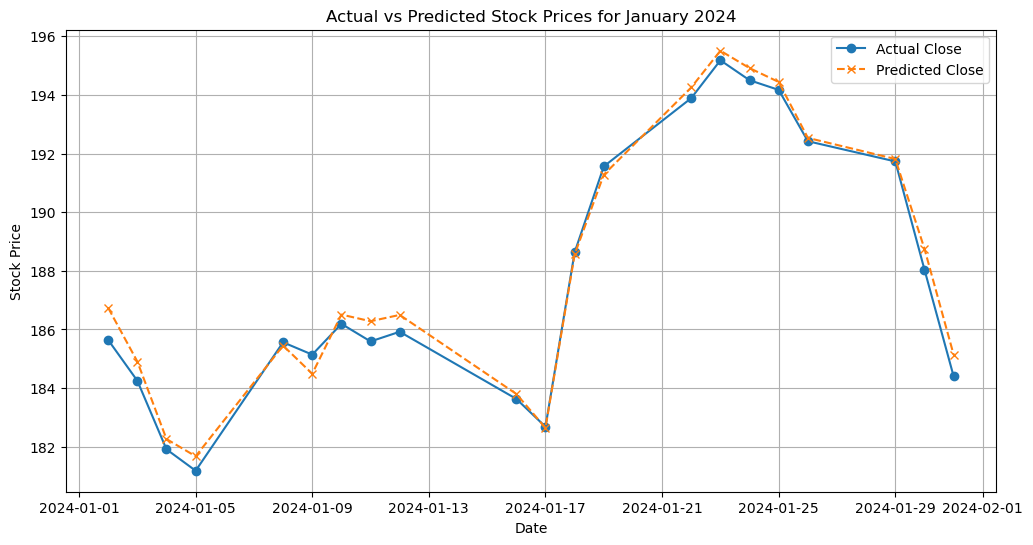

In [77]:
# Plot actual vs predicted without merging the dataframes
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close', marker='o')

# Plot predicted prices
plt.plot(results['Date'], results['Predicted_Close'], label='Predicted Close', linestyle='--', marker='x')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for January 2024')
plt.legend()
plt.grid(True)
plt.show()
